#### Load Dependencies

In [966]:
from clearml import Dataset, TaskTypes, Task, Logger
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, \
                            ConfusionMatrixDisplay, precision_recall_fscore_support, PrecisionRecallDisplay
import numpy as np
import matplotlib.pyplot as plt
import joblib
plt.rcParams['figure.figsize'] = [20, 15]

#### ClearML

In [967]:
task = Task.init('RCM_Claims_Denial_mgmt','Model Training',task_type=TaskTypes.training)

Could not read Jupyter Notebook: No module named 'nbconvert'


ClearML Task: created new task id=09d520a8c6b648208ea1da67db5e5937
ClearML results page: http://3.111.229.37:8080/projects/37a0acef88f847c1a5af15a811add6d7/experiments/09d520a8c6b648208ea1da67db5e5937/output/log


#### Load and Prepare Data

In [968]:
dataset = Dataset.get('5029b29e001945cf8514b2462fd1c1d2')
download_path = dataset.get_local_copy()

dumy_encoded = pd.read_csv(download_path + '/preprocessed_cat_encoded.csv')

ClearML results page: http://3.111.229.37:8080/projects/37a0acef88f847c1a5af15a811add6d7/experiments/09d520a8c6b648208ea1da67db5e5937/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [969]:
download_path

'/home/abhijitbarman/.clearml/cache/storage_manager/datasets/ds_5029b29e001945cf8514b2462fd1c1d2'

Since Denial Category & Approved Charges cannot be known in advance, discarding Denial Category & Approved_Charge.

In [ ]:
#Took care while preprocessing
""" denial_categories = [col for col in dumy_encoded.columns if 'DENIAL' in col]
denial_categories.append('APPROVED_CHARGE')
denial_categories

dumy_encoded.drop(columns=denial_categories,inplace=True,axis=1)
dumy_encoded.shape
 """


**Create X & y**

In [970]:
X = dumy_encoded.drop(columns='REASON_CODE')
y = dumy_encoded['REASON_CODE']

**Split Data**

In [971]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

In [972]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4178, 564), (1393, 564), (4178,), (1393,))

In [973]:
y_train[:5]

3725     1.0
726     21.0
3696     1.0
928     90.0
5170     1.0
Name: REASON_CODE, dtype: float64

In [974]:
X_train.to_csv('X_train.csv', index=False)

In [975]:
X_train.shape

(4178, 564)

**Encode Labels**

In [976]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [977]:
joblib.dump(label_encoder,'label_encoder.joblib')
# add and upload local file artifac
task.upload_artifact(
    'local file', 
    artifact_object='label_encoder.joblib'
)


True

**Feature Normalization**

In [978]:
norm_features = ['Age', 'TOTAL_CHARGES', 'SERVICE_UNIT_QUANTITY']
scaler = MinMaxScaler()
scaler.fit(X_train[norm_features])

MinMaxScaler()

In [979]:
scaled = scaler.transform(X_train[norm_features])
X_train['Age'] =  scaled[:,0]
X_train['TOTAL_CHARGES'] = scaled[:,1]
X_train['SERVICE_UNIT_QUANTITY'] = scaled[:,2]
X_train.shape

(4178, 564)

In [980]:
scaled = scaler.transform(X_test[norm_features])

X_test['Age'] =  scaled[:,0]
X_test['TOTAL_CHARGES'] =  scaled[:,1]
X_test['SERVICE_UNIT_QUANTITY'] = scaled[:,2]

X_test.shape

(1393, 564)

### Model Training 

#### Logistic Regression

In [981]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial')
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [982]:
test_preds = lr_model.predict(X_test)
train_preds = lr_model.predict(X_train)

In [983]:
'Confidence' in X_test.columns

False

In [984]:
print(f'LogisticRegression Test Accuracy: {accuracy_score(y_test, test_preds) * 100:.2f}')
print(f'LogisticRegression Train Accuracy: {accuracy_score(y_train, train_preds) * 100:.2f}')

LogisticRegression Test Accuracy: 97.20
LogisticRegression Train Accuracy: 98.23


**LogisticRegression: Classification Report**

In [985]:
#TRAINING
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2761
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        22
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        22
          13       1.00      1.00      1.00        22
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        22
          16       1.00      1.00      1.00        22
          17       0.23    

FOR PLOTTING

In [986]:
all_classes= np.unique(y_train).tolist()
color_names = ['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black',
               'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse',
               'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue',
               'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen', 'darkkhaki', 'darkmagenta',
               'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
               'darkslateblue', 'darkslategray']
disP_labels  = [str(int(i)) for i in sorted(y.unique().tolist())]

In [987]:
def plot_roc(model,X_test,y_test, all_classes):
  # Predict the probabilities for the test data
  y_score = model.predict_proba(X_test)

  # Binarize the labels (convert to one-hot encoding)
  y_test_bin = label_binarize(y_test, classes=all_classes)
  n_classes = y_test_bin.shape[1]

  # Calculate the ROC curve and AUC score for each class
  fpr = {}
  tpr = {}
  roc_auc = {}

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot the ROC curves for each class
  plt.figure(figsize=(10,10))
  colors = color_names # cycle(['blue','red','green','yellow','pink','orange','magenta','black'])

  for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
    ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic (ROC) curve')
  plt.legend(loc="lower right")
  plt.show()

In [988]:
def plot_cm(y_test,pred_test,disP_labels, my_cmap='Blues'):
    # Compute confusion matrix
    cm = confusion_matrix(y_test,pred_test)

    # Display confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disP_labels)
    disp.plot(cmap=my_cmap)

    # Set plot properties
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

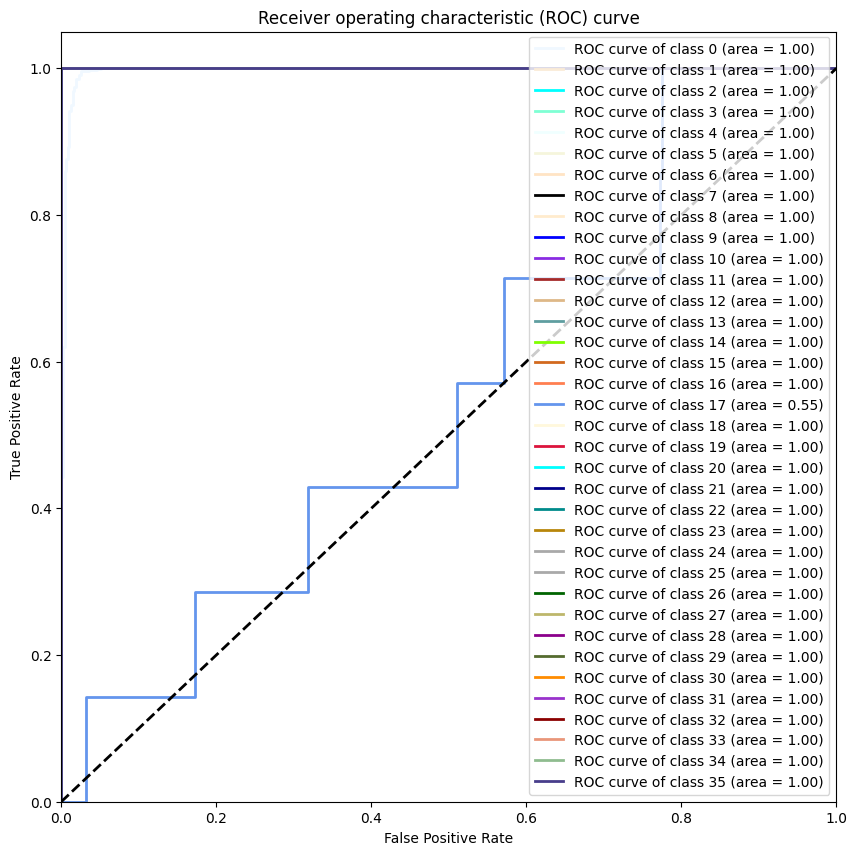

In [989]:
plot_roc(lr_model,X_test,y_test, all_classes)

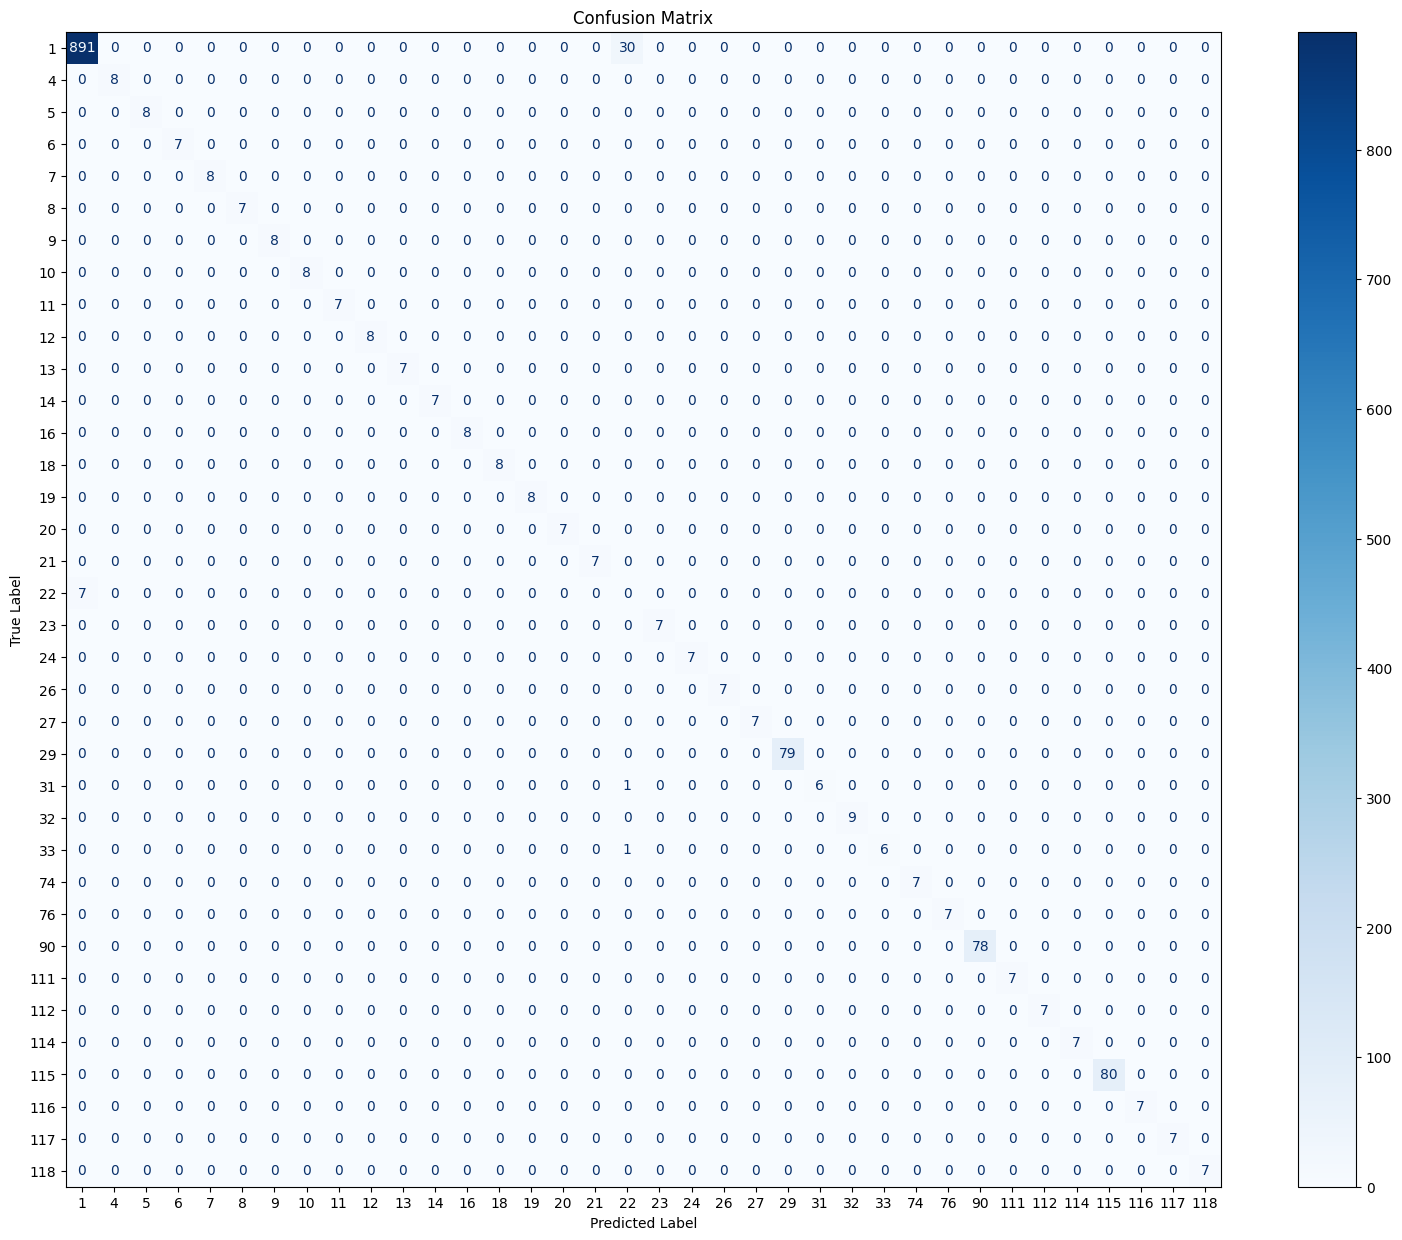

In [990]:
plot_cm(y_test, test_preds, disP_labels)

#### Decision Tree

In [991]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [992]:
pred_test= dt_model.predict(X_test)
pred_train= dt_model.predict(X_train)

In [993]:
print(f'DecisionTreeClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'DecisionTreeClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

DecisionTreeClassifier Test Accuracy: 99.28
DecisionTreeClassifier Train Accuracy: 100.00


**LogisticRegression: Classification Report**

In [994]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       921
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         7
          16       1.00      1.00      1.00         7
          17       0.33    

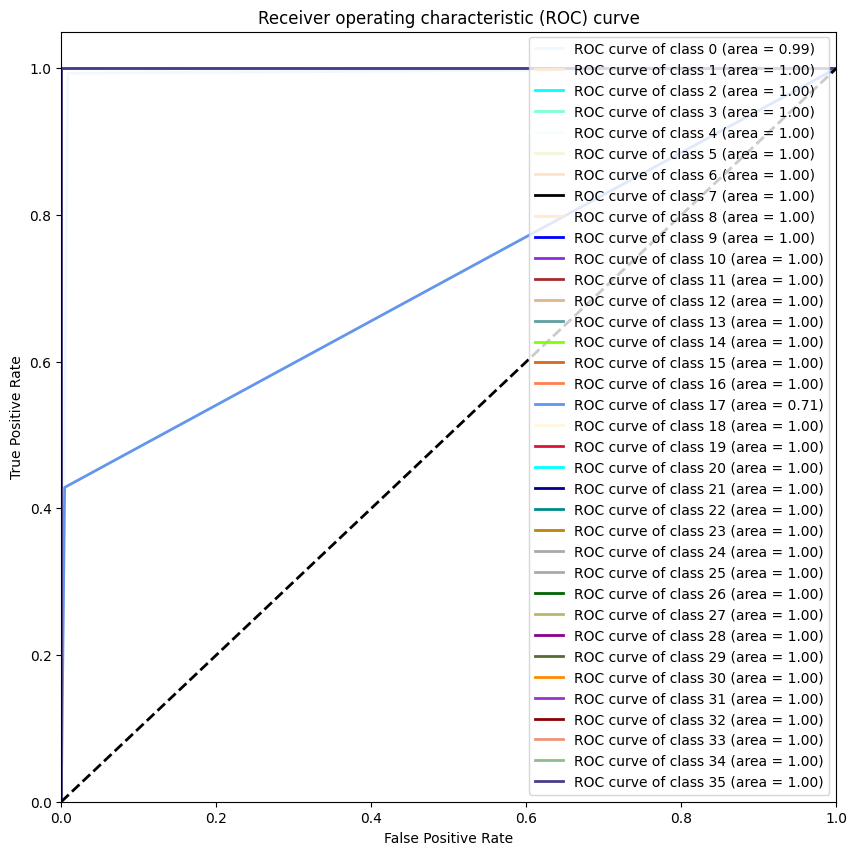

In [995]:
plot_roc(dt_model, X_test, y_test,all_classes)

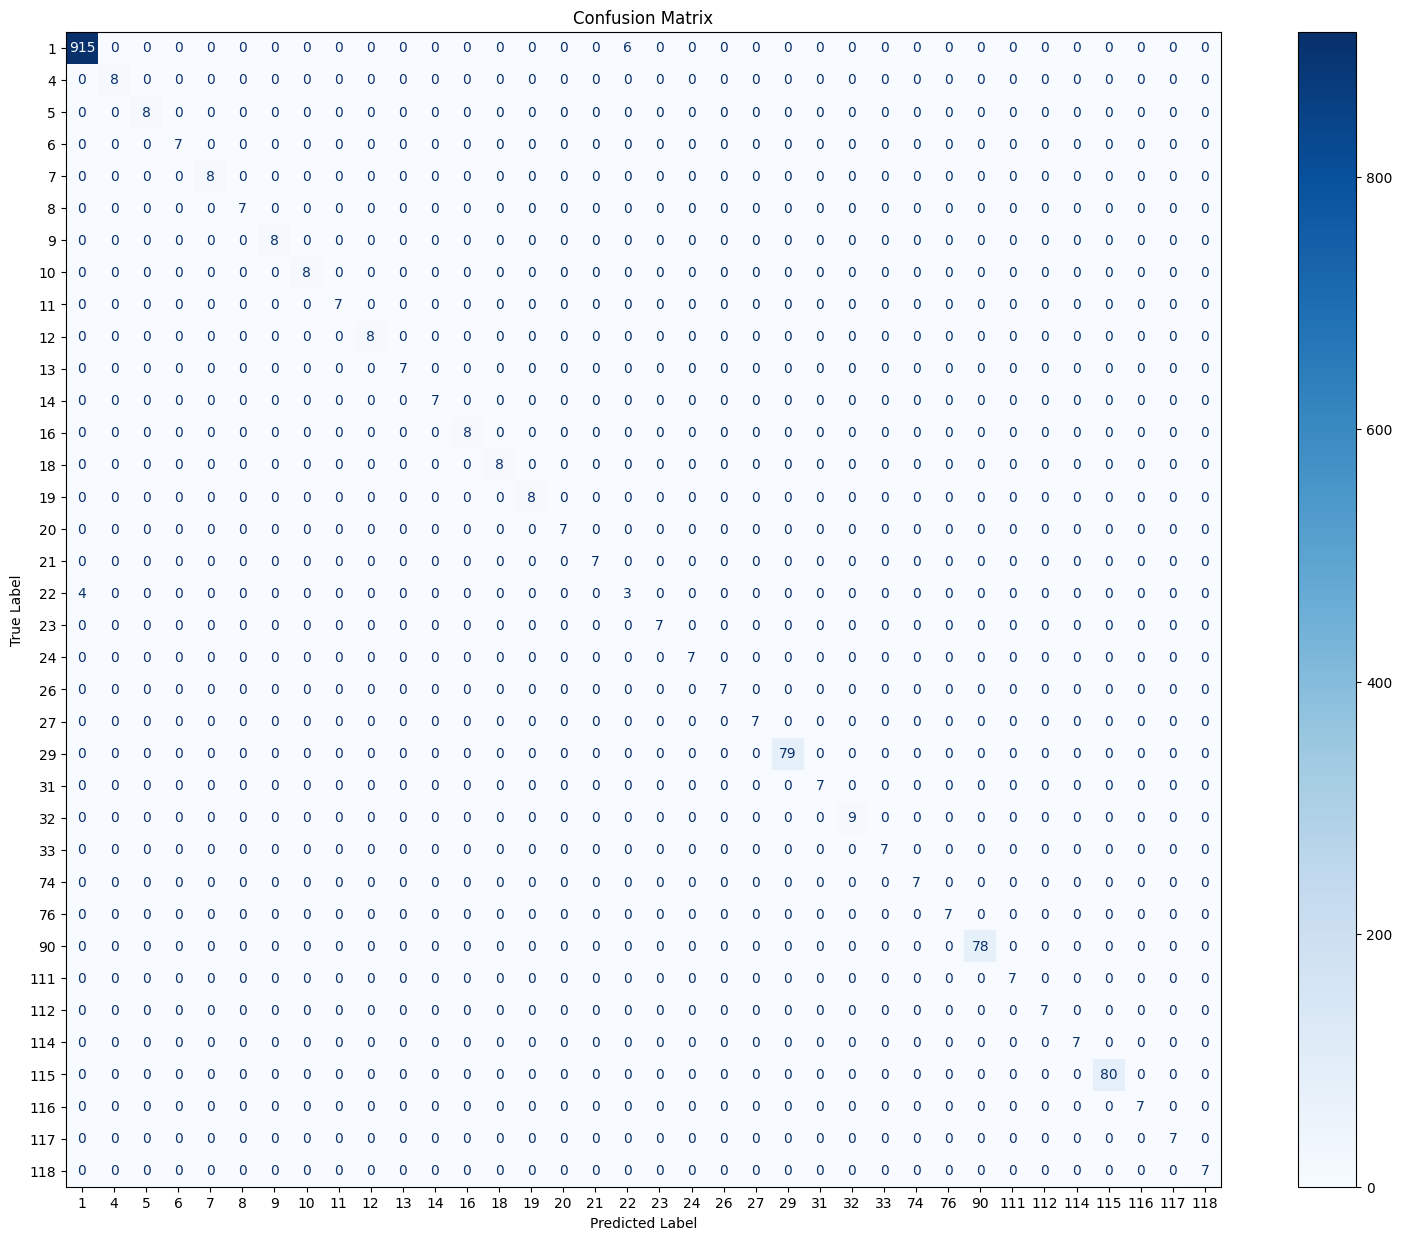

In [996]:
plot_cm(y_test,pred_test,disP_labels)

#### Random forest Classifier

In [997]:
rf_model = RandomForestClassifier(random_state = 24, n_jobs = -1, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=24)

In [998]:
pred_train = rf_model.predict(X_train)
pred_test = rf_model.predict(X_test)

In [999]:
print(f'RandomForestClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'RandomForestClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

RandomForestClassifier Test Accuracy: 99.50
RandomForestClassifier Train Accuracy: 100.00


In [1000]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       921
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         7
          16       1.00      1.00      1.00         7
          17       0.00    

/home/abhijitbarman/abhijit/WS/envs/claims_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/abhijitbarman/abhijit/WS/envs/claims_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/abhijitbarman/abhijit/WS/envs/claims_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



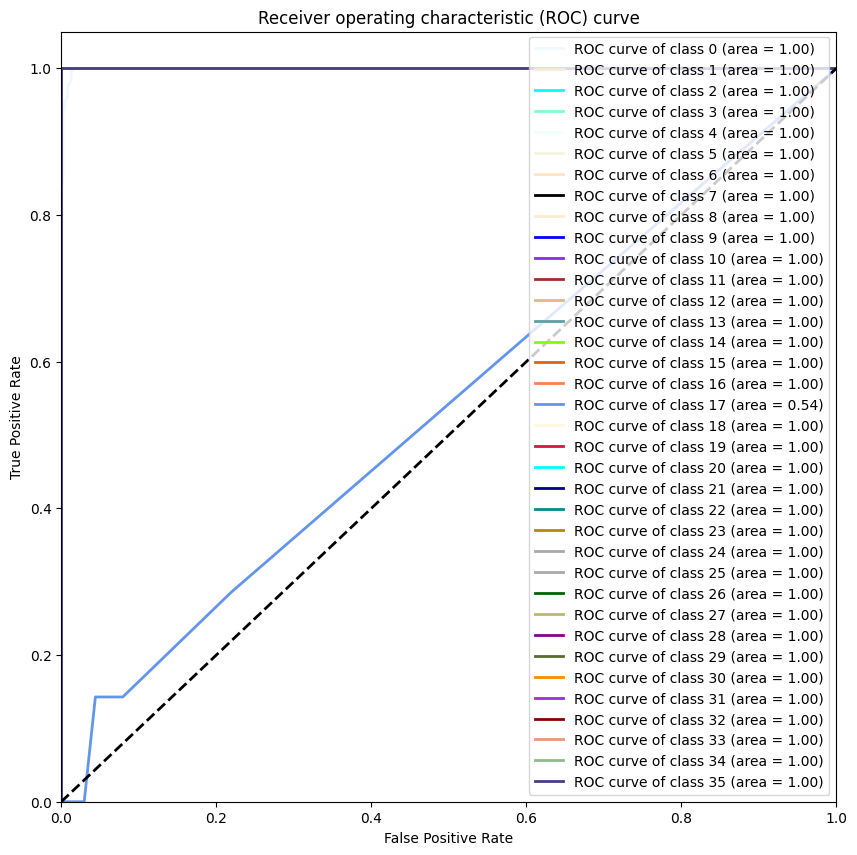

In [1001]:
plot_roc(rf_model,X_test,y_test, all_classes)

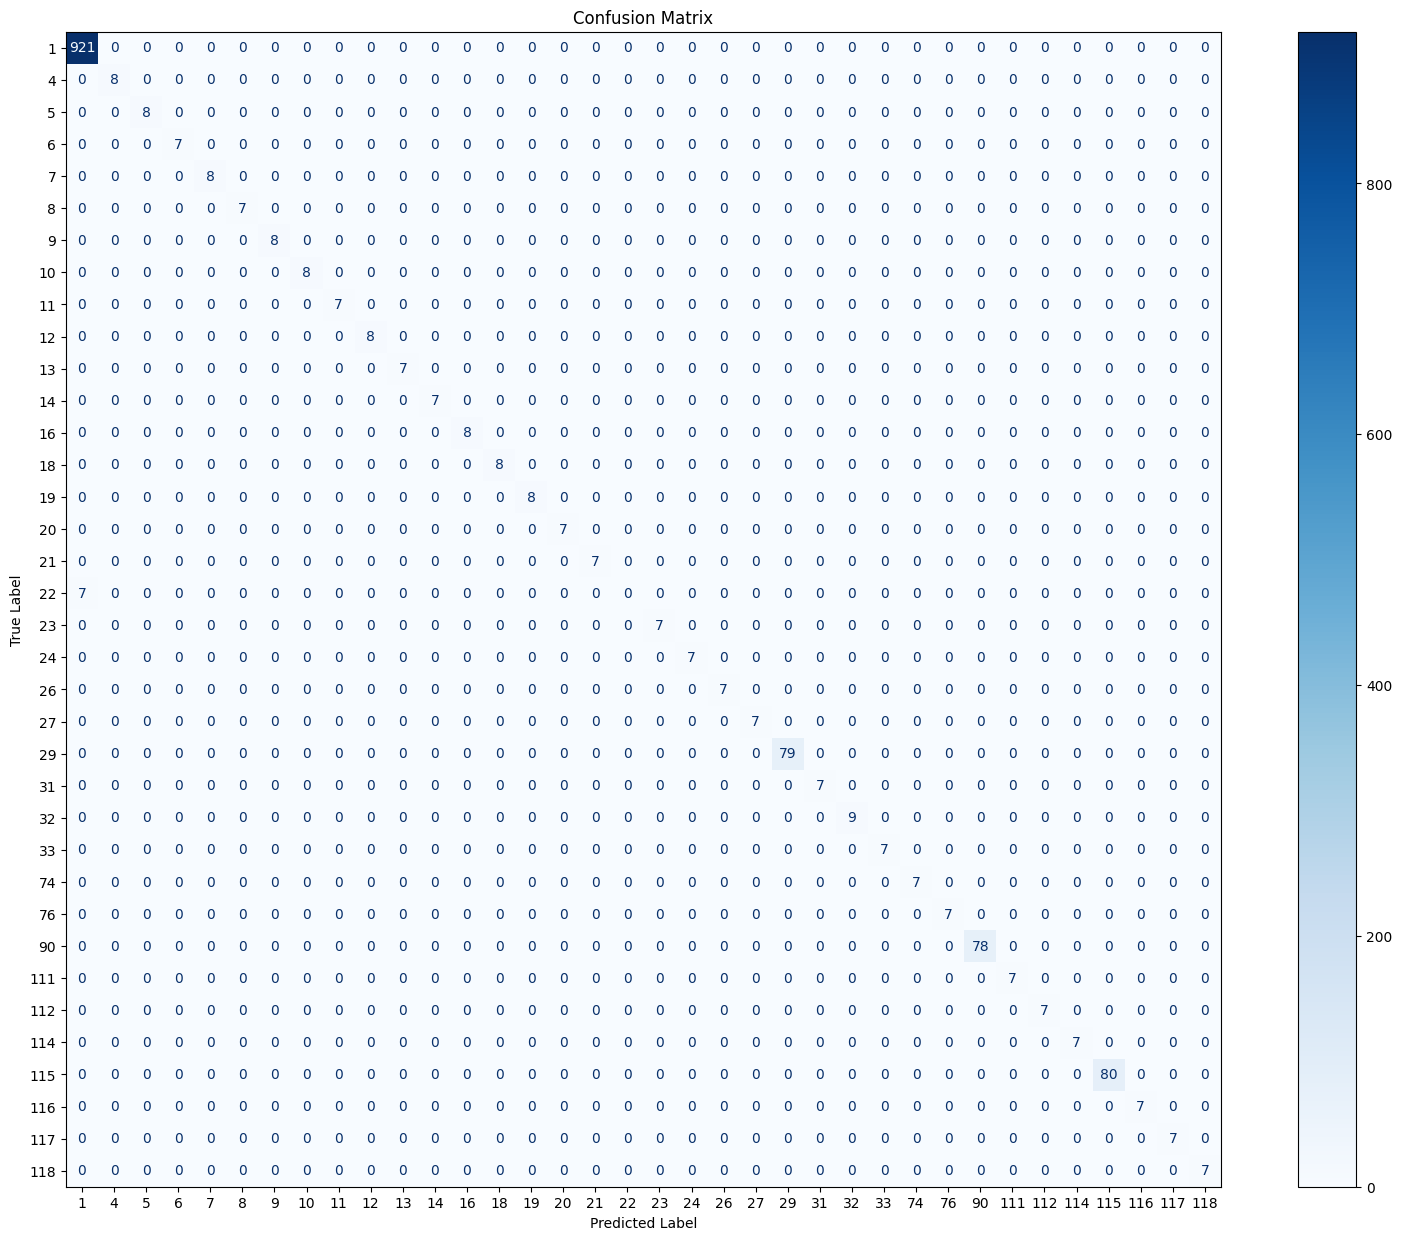

In [1002]:
plot_cm(y_test,pred_test,disP_labels)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


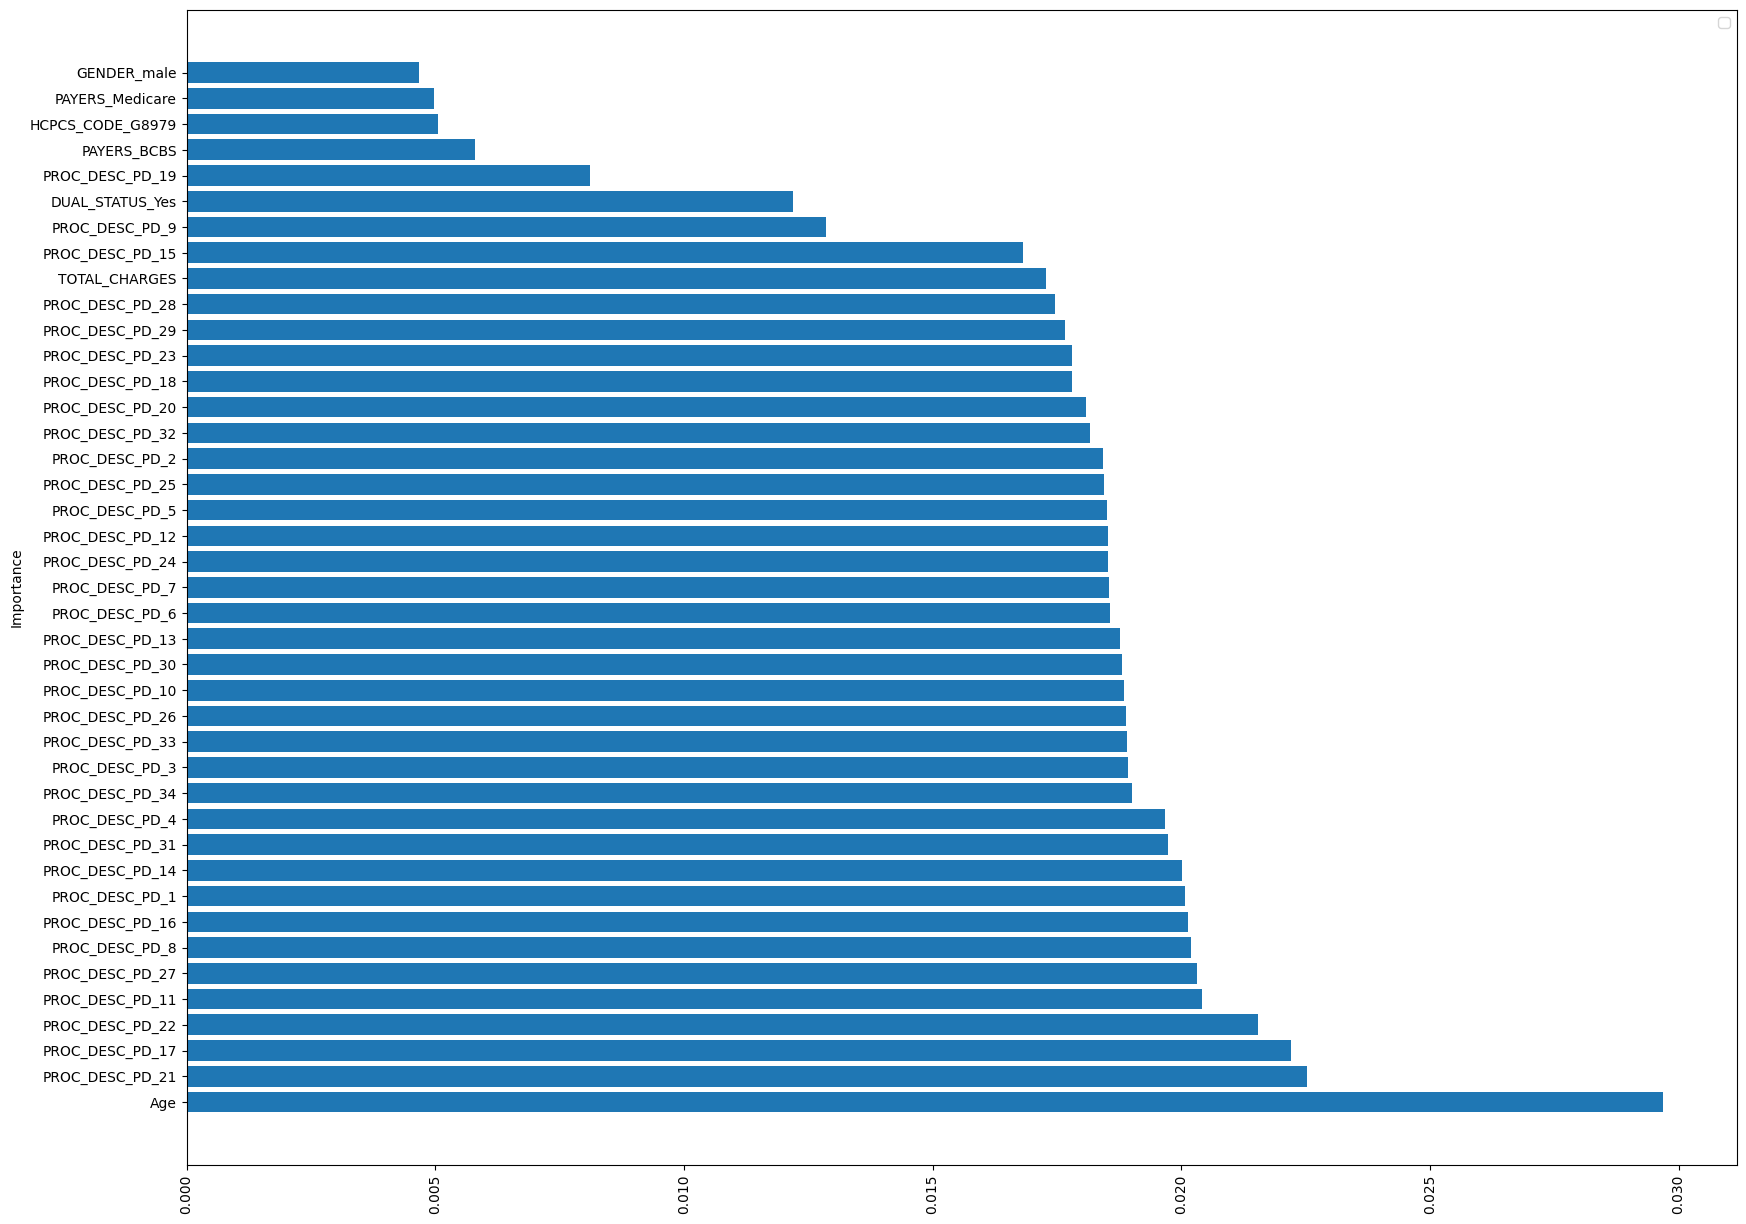

In [1003]:
# sort feature importances in descending order
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]
sorted_names = [X_test.columns[i] for i in indices]
sorted_importances = importances[indices]

# plot feature importances as a sorted bar plot
plt.barh(sorted_names[:41], sorted_importances[:41], )
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.show()

In [1004]:
joblib.dump(rf_model, "./random_forest.joblib")

['./random_forest.joblib']

In [1005]:
task.close()

In [1007]:
label_encoder.inverse_transform([17])

array([22.])

In [1008]:
label_encoder.classes_

array([  1.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  16.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  26.,  27.,
        29.,  31.,  32.,  33.,  74.,  76.,  90., 111., 112., 114., 115.,
       116., 117., 118.])

### Report Generation

In [1009]:
report = classification_report(y_test,pred_test)

/home/abhijitbarman/abhijit/WS/envs/claims_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/abhijitbarman/abhijit/WS/envs/claims_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/abhijitbarman/abhijit/WS/envs/claims_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [1010]:
with open("classification_report.txt", "w") as f:
    f.write(report)

In [1011]:
y_score = rf_model.predict_proba(X_test)

In [1012]:
prediction_confidence = []
predicted_label_index = []
predicted_label = []
for row in y_score:
    index = row.argmax()
    predicted_label_index.append(index)
    prediction_confidence.append(row[index])
    if index != 0:
        index -= 1
    predicted_label.append(disP_labels[index])

In [1018]:
y_test

array([2, 0, 0, ..., 0, 0, 0])

In [1013]:
actual = label_encoder.inverse_transform(y_test)
predcted = label_encoder.inverse_transform(predicted_label_index)

In [1014]:
df = pd.DataFrame({'Actual':actual, 'Predicted':predcted,
                   'Confidence_Score':prediction_confidence})

In [1015]:
df.to_csv('Report.csv', index=False)

In [1016]:
""" 
df = pd.DataFrame({'Predicted_Label':predicted_label, 'Predicted_Label_Index':predicted_label_index
              ,'Ground_Truth_Label_Index':y_test,'Confidence_Score':prediction_confidence})

df.to_csv('report.csv', index=False)         
test=X_test
test['Label'] = y_test
test['Confidence'] = prediction_confidence
true_labels = [disP_labels[i] for i in y_test] """

" \ndf = pd.DataFrame({'Predicted_Label':predicted_label, 'Predicted_Label_Index':predicted_label_index\n              ,'Ground_Truth_Label_Index':y_test,'Confidence_Score':prediction_confidence})\n\ndf.to_csv('report.csv', index=False)         \ntest=X_test\ntest['Label'] = y_test\ntest['Confidence'] = prediction_confidence\ntrue_labels = [disP_labels[i] for i in y_test] "

(2,)

In [ ]:
r[]